In [1]:
%pylab inline
import random
import msgpack
import numpy as np
import pandas as pd


Populating the interactive namespace from numpy and matplotlib


In [2]:
edges_file = edges_file = "archive/17_create_coeditor/2017-04-26 14:53:15 1b4e2e0/%d-coeditor.mp"
path_file = "archive/20_find_path_length/2017-05-05 13:28:24 dbe068d/%04d-path_length.csv"
project_id = 675

In [3]:
edges_from = {}
all_nodes = set()
with open(edges_file % project_id, "rb") as f:
    unpacker = msgpack.Unpacker(f)
    for o in unpacker:
        edges_from[o[0][0]] = o[1]
        all_nodes.add(o[0][0])
        all_nodes |= set(o[1])
node_count = len(all_nodes)

In [4]:
all_recip = {}
with open(path_file % project_id) as f:
    for row in f:
        proj, src, tar, length = row.rstrip().split(',')
        if src == tar:
            continue
        all_recip[(int(src),int(tar))] = 1.0/float(length)

In [5]:
def sources_by_degree(edges_from):
    '''Create N sources in each of M out-degree strata.'''
    # Create list of all nodes and degrees
    node_out_degree = {}
    for source, targets in edges_from.iteritems():
        node_out_degree[source] = len(targets)
        for target in targets:
            node_out_degree[target] = node_out_degree.get(target, 0)
    # Sort nodes by degrees
    nodes_out = sorted(node_out_degree.items(), key=lambda x: x[1])
    return nodes_out


In [30]:
by_degree = [x[0] for x in sources_by_degree(edges_from)]
highest = by_degree[-(node_count/10):]
lowest = by_degree[0:(node_count/10)]
step = int(ceil(node_count/10.0))
partitions = [by_degree[x*step:((x+1)*step)] for x in range(10)]


In [14]:
tot = 0.0
count = 0
for source in by_degree:
    for target in all_nodes:
        if source == target:
            continue
        tot += all_recip.get((source, target), 0.0)
        count += 1
true_harmonic = float(count) / tot

In [8]:
tot = 0.0
count = 0
for source in highest:
    for target in all_nodes:
        if source == target:
            continue
        tot += all_recip.get((source, target), 0.0)
        count += 1
true_highest = float(count) / tot

In [9]:
tot = 0.0
count = 0
for source in lowest:
    for target in all_nodes:
        if source == target:
            continue
        tot += all_recip.get((source, target), 0.0)
        count += 1
true_lowest = float(count) / tot

In [10]:
trials = 30.0
highest_errors = []
all_N = range(10,100)
print len(all_N), " items"
for N in all_N:
    error_tot = 0.0
    for i in range(int(trials)):
        subset = random.sample(highest, N)
        tot = 0.0
        count = 0
        for source in subset:
            for target in all_nodes:
                if source == target:
                    continue
                tot += all_recip.get((source, target), 0.0)
                count += 1
        error_tot += abs(true_highest - (float(count) / tot))
    highest_errors.append(error_tot / trials)

90  items


In [11]:
trials = 30.0
lowest_errors = []
all_N = range(10,100)
print len(all_N), " items"
for N in all_N:
    error_tot = 0.0
    for i in range(int(trials)):
        subset = random.sample(lowest, N)
        tot = 0.0
        count = 0
        for source in subset:
            for target in all_nodes:
                if source == target:
                    continue
                tot += all_recip.get((source, target), 0.0)
                count += 1
        error_tot += abs(true_lowest - (float(count) / tot))
    lowest_errors.append(error_tot / trials)

90  items


In [34]:
trials = 30.0
overall_errors=[]
all_N = range(10,100)
print len(all_N), " items"
for N in all_N:
    error_tot = 0.0
    for i in range(int(trials)):
        tot = 0.0
        count = 0
        for part in range(10):
            subset = random.sample(partitions[part], N)
            for source in subset:
                for target in all_nodes:
                    if source == target:
                        continue
                    tot += all_recip.get((source, target), 0.0)
                    count += 1
        error_tot += abs(true_harmonic - (float(count) / tot))
    overall_errors.append(error_tot / trials)

90  items


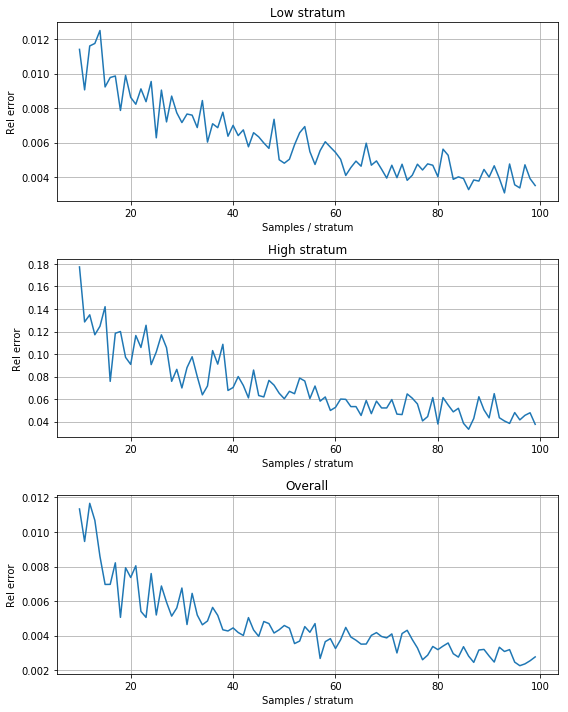

In [37]:
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.plot(all_N, np.array(highest_errors) / true_highest)
plt.grid()
title("Low stratum")
xlabel("Samples / stratum")
ylabel("Rel error")
plt.subplot(3,1,2)
plt.plot(all_N, np.array(lowest_errors) / true_lowest)
plt.grid()
title("High stratum")
xlabel("Samples / stratum")
ylabel("Rel error")
plt.subplot(3,1,3)
plt.plot(all_N, np.array(overall_errors) / true_harmonic)
plt.grid()
title("Overall")
xlabel("Samples / stratum")
ylabel("Rel error")
plt.tight_layout()